In [ ]:
import torch
from torch import nn
import numpy as np
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Load Dataset for CIFAR

In [ ]:
init_trans = transforms.Compose([
    ToTensor(),
    Normalize((0.5,0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = CIFAR10(root='data/', train=True, download=True, transform=init_trans)
test_ds = CIFAR10(root='data/', train=False, download=True, transform=init_trans)

100%|██████████| 170498071/170498071 [00:10<00:00, 15763134.36it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get visual for data

In [ ]:
examples = enumerate(DataLoader(dataset, 16, shuffle=True))
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([16, 3, 32, 32])

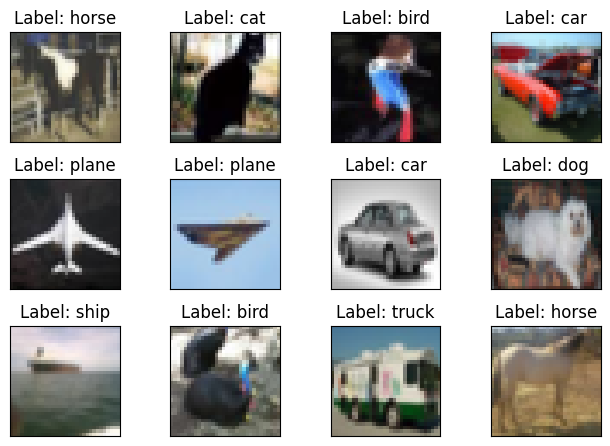

In [ ]:
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    # Unnoramlize image and transpose (inputs are channel, height, width)
    image = example_data[i] * 0.5 + 0.5
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.title(f"Label: {classes[example_targets[i]]}")
    plt.xticks([])
    plt.yticks([])

plt.show()

# Building the CNN

## Model

In [ ]:
class MyCNN(nn.Module):
    def __init__(
        self,
        epochs=10,
        learning_rate=0.01,
        batch_size=64,
        weight_decay=0,
        momentum=0,
        gamma=0.1,
        device=None
        ):
        super(MyCNN, self).__init__()
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.gamma = gamma
        self.device = device if device != None else torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.criterion = nn.CrossEntropyLoss()

        # Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 7, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.fc1 = nn.Sequential(
            nn.Linear(64*7*7, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512, 256),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.conv3(x)
        # print(x.shape)
        x = self.conv4(x)
        # print(x.shape)
        x = self.conv5(x)
        # print(x.shape)
        x = self.dropout2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # output = F.log_softmax(x, dim=1)
        return self.output(x)

    def make_optimizer(self):
        return optim.SGD(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay,
            momentum=self.momentum,
            nesterov=True,
        )

    def make_schedule(self, optimizer):
        return StepLR(optimizer, step_size=self.epochs//4, gamma=self.gamma)

## Training Functions

### Validate

In [ ]:
def validate_model(model: MyCNN, validation_loader: DataLoader, train_loader: DataLoader = None):
    model.eval()
    validation_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(model.device), target.to(model.device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item()  # Calculate the validation loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the maximum log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()  # Count correct predictions

    validation_loss /= len(validation_loader.dataset)
    accuracy = correct / len(validation_loader.dataset)

    return validation_loss, accuracy

### Train Loop

In [ ]:
def train(model: MyCNN, train_loader: DataLoader, val_loader: DataLoader, schedule=None):
    model.to(model.device)
    train_losses = []
    train_counter = []

    optimizer = model.make_optimizer()
    if schedule:
        scheduler = model.make_schedule(optimizer)

    # For early stopping
    best_accuracy = 0.0
    earlystop_patience = 5
    earlystop_count = 0

    # Adding transforms to data to make less dependent on training data
    additional_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(size=32, padding=4),
    ])

    for epoch in range(model.epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(model.device), labels.to(model.device)

            if not inputs.is_cuda:
                print(f"Batch {i}, input-type={inputs.type()}, label-type={labels.type()}, device={model.device}")

            augment_input = additional_transforms(inputs)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(augment_input)

            # Calculate the loss
            loss = model.criterion(outputs, labels)

            # Backpropagation
            loss.backward()

            # Update the weights
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 batches
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.4f}')
                # Store train loss
                train_losses.append(running_loss / 100)
                train_counter.append(
                    epoch + (i / len(train_loader))
                )
                running_loss = 0.0

        if schedule:
            scheduler.step()

        # Compute Training accuracy
        train_loss, train_accuracy = validate_model(model, train_loader)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")

        # Validation
        validation_loss, validation_accuracy = validate_model(model, val_loader)
        print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy * 100:.2f}%")

        # Check Early Stopping
        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            earlystop_count = 0
        else:
            earlystop_count += 1

        if earlystop_count > earlystop_patience:
            print(f"Early stopping! No improvement for the last {earlystop_patience} epochs.")
            break

    plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.xlabel('Epoch (values between ints indicate batches)')
    plt.ylabel('Training Loss')
    plt.title('Training Loss vs. Epoch')
    plt.show()

## Testing

In [ ]:
def test(model: MyCNN, test_loader: DataLoader, classes):
    model.eval()
    test_loss = 0
    # correct = 0

    # For class count predictions
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(model.device), targets.to(model.device)
            output = model(data)
            test_loss += F.nll_loss(output, targets, reduction='sum').item()  # Calculate the test loss
            preds = output.argmax(dim=1, keepdim=True)  # Get the index of the maximum log-probability
            for pred, label in zip(preds, targets):
                correct_pred[classes[label]] += pred.eq(label.view_as(pred)).item()  # Count correct predictions
                total_pred[classes[label]] += 1

    # print accuracy for each class
    correct = 0
    for classname, correct_count in correct_pred.items():
        correct += correct_count
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {correct_count}/{total_pred[classname]} ({accuracy:.2f}%)')

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

# Running the Model

In [ ]:
model = MyCNN(momentum=0.9, learning_rate=0.1, epochs=50, weight_decay=1e-4, batch_size=128)

In [ ]:
num_workers = 2 if 'cuda' in model.device.type else 0
pin_memory = True if 'cuda' in model.device.type else False

train_loader = DataLoader(train_dataset, model.batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, model.batch_size, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_ds, model.batch_size, num_workers=num_workers, pin_memory=pin_memory)

Epoch 1, Batch 100, Loss: 1.9477
Epoch 1, Batch 200, Loss: 1.6713
Epoch 1, Batch 300, Loss: 1.6057
Train Loss: -2.3486, Train Accuracy: 43.31%
Validation Loss: -2.3359, Validation Accuracy: 43.18%
Epoch 2, Batch 100, Loss: 1.4871
Epoch 2, Batch 200, Loss: 1.4134
Epoch 2, Batch 300, Loss: 1.3384
Train Loss: -3.2611, Train Accuracy: 56.82%
Validation Loss: -3.2214, Validation Accuracy: 56.22%
Epoch 3, Batch 100, Loss: 1.2367
Epoch 3, Batch 200, Loss: 1.1840
Epoch 3, Batch 300, Loss: 1.1832
Train Loss: -3.9096, Train Accuracy: 61.80%
Validation Loss: -3.8749, Validation Accuracy: 61.76%
Epoch 4, Batch 100, Loss: 1.0971
Epoch 4, Batch 200, Loss: 1.0596
Epoch 4, Batch 300, Loss: 1.0597
Train Loss: -4.3726, Train Accuracy: 69.05%
Validation Loss: -4.3169, Validation Accuracy: 68.36%
Epoch 5, Batch 100, Loss: 0.9821
Epoch 5, Batch 200, Loss: 0.9770
Epoch 5, Batch 300, Loss: 0.9521
Train Loss: -4.8203, Train Accuracy: 73.00%
Validation Loss: -4.7193, Validation Accuracy: 71.88%
Epoch 6, Batch 

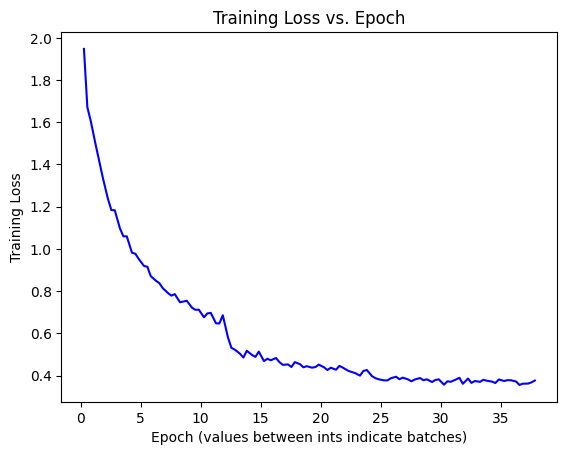

In [ ]:
train(model, train_loader, val_loader, schedule=True)

In [ ]:
test(model, train_loader, classes)

Accuracy for class: plane is 4190/4506 (92.99%)
Accuracy for class: car   is 4341/4490 (96.68%)
Accuracy for class: bird  is 3976/4492 (88.51%)
Accuracy for class: cat   is 3390/4502 (75.30%)
Accuracy for class: deer  is 4185/4501 (92.98%)
Accuracy for class: dog   is 3871/4521 (85.62%)
Accuracy for class: frog  is 4314/4510 (95.65%)
Accuracy for class: horse is 4261/4484 (95.03%)
Accuracy for class: ship  is 4370/4505 (97.00%)
Accuracy for class: truck is 4333/4489 (96.52%)

Test set: Average loss: -8.7092, Accuracy: 41231/45000 (91.62%)


In [ ]:
test(model, test_loader, classes)

Accuracy for class: plane is 858/1000 (85.80%)
Accuracy for class: car   is 932/1000 (93.20%)
Accuracy for class: bird  is 801/1000 (80.10%)
Accuracy for class: cat   is 633/1000 (63.30%)
Accuracy for class: deer  is 870/1000 (87.00%)
Accuracy for class: dog   is 803/1000 (80.30%)
Accuracy for class: frog  is 922/1000 (92.20%)
Accuracy for class: horse is 901/1000 (90.10%)
Accuracy for class: ship  is 920/1000 (92.00%)
Accuracy for class: truck is 924/1000 (92.40%)

Test set: Average loss: -8.3799, Accuracy: 8564/10000 (85.64%)


# Saving / Reloading Model

In [ ]:
# Note parent dir must exist and you must mount to drive to save this way.
# You can just save to root and it will make a tmp file if you do not want to mount drive and set up additional files
def save_model(model, name, parent_dir="drive/MyDrive/Colab Notebooks/CIFAR10/models"):
    torch.save(model, f"{parent_dir}/{name}.pth")

In [ ]:
def load_model(name, parent_dir="drive/MyDrive/Colab Notebooks/CIFAR10/models"):
    model = torch.load(f"{parent_dir}/{name}.pth")
    model.eval()
    return model

In [ ]:
save_model(model, "85_64-Test")

In [ ]:
model = load_model("85_64-Test")